In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import wget
import subprocess
import os
import shapefile
import datetime as dt
from shapely.geometry import Point, Polygon

In [50]:
# Make a data folder
if not os.path.isdir("data"):
    os.mkdir("data")

# Make yield folder
if not os.path.isdir("data/yield"):
    os.mkdir("data/yield")

# Make ushcn folder
if not os.path.isdir("data/ushcn"):
    os.mkdir("data/ushcn")

# Make counties folder
if not os.path.isdir("data/counties"):
    os.mkdir("data/counties")
    
# Make states folder
if not os.path.isdir("data/states"):
    os.mkdir("data/states")    

## Corn yield data

In [3]:
# # Make API call
# url = "http://quickstats.nass.usda.gov/api/api_GET/?" + \
#     "key={}&".format(os.environ["NASS_API_KEY"]) + \
#     "commodity_desc=CORN&" + \
#     "group_desc=FIELD CROPS&" + \
#     "sector_desc=CROPS&" + \
#     "source_desc=SURVEY&" + \
#     "statisticcat_desc=YIELD&" + \
#     "short_desc__NOT_LIKE=SILAGE&" + \
#     "county_ansi__NE=''&" + \
#     "year__GE=2000&" + \
#     "state_ansi__NE=''&" + \
#     "format=JSON"

# response = requests.get(url)  

# # Create DataFrame
# data = response.json()
# df = pd.DataFrame(data["data"])

# # Clean the data
# df["Value"] = df.Value.map(float)
# df["year"] = df.year.map(int) - 2000

# # Save data
# df.to_csv("data/yield/yield_data.csv", index=False)

In [119]:
df = pd.read_csv("data/yield/yield_data.csv")
df["fips"] = df.state_fips_code.map(lambda x: str(x).zfill(2)) + \
    df.county_code.map(lambda x: str(x).zfill(3))
df.to_dict(outtype="records")[0]

{'CV (%)': nan,
 'Value': 191.5,
 'agg_level_desc': 'COUNTY',
 'asd_code': 10,
 'asd_desc': 'NORTHERN VALLEY',
 'begin_code': 0,
 'class_desc': 'ALL CLASSES',
 'commodity_desc': 'CORN',
 'congr_district_code': nan,
 'country_code': 9000,
 'country_name': 'UNITED STATES',
 'county_ansi': 33,
 'county_code': 33,
 'county_name': 'COLBERT',
 'domain_desc': 'TOTAL',
 'domaincat_desc': 'NOT SPECIFIED',
 'end_code': 0,
 'fips': '01033',
 'freq_desc': 'ANNUAL',
 'group_desc': 'FIELD CROPS',
 'load_time': '2015-02-19 15:38:52',
 'location_desc': 'ALABAMA, NORTHERN VALLEY, COLBERT',
 'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
 'reference_period_desc': 'YEAR',
 'region_desc': nan,
 'sector_desc': 'CROPS',
 'short_desc': 'CORN, GRAIN - YIELD, MEASURED IN BU / ACRE',
 'source_desc': 'SURVEY',
 'state_alpha': 'AL',
 'state_ansi': 1,
 'state_fips_code': 1,
 'state_name': 'ALABAMA',
 'statisticcat_desc': 'YIELD',
 'unit_desc': 'BU / ACRE',
 'util_practice_desc': 'GRAIN',
 'watershed_code': 0,


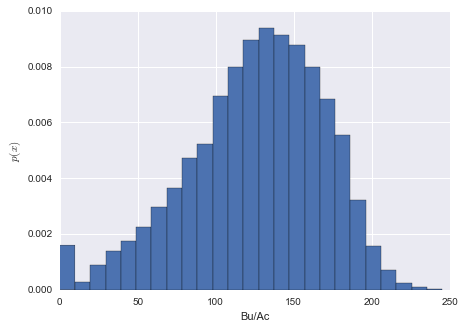

In [5]:
# Distribution of yield in Bu/Ac
plt.figure(figsize=(7, 5))
plt.hist(df.Value, bins=25, normed=True)
plt.xlabel("Bu/Ac")
plt.ylabel("$p(x)$")
plt.show()

In [6]:
# Fit OLS
X = sm.add_constant(df.year)
ols = sm.OLS(df.Value, X)
model = ols.fit()
b0, b1 = model.params.const, model.params.year
print model.summary().as_text()

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1539.
Date:                Sat, 18 Apr 2015   Prob (F-statistic):               0.00
Time:                        14:30:29   Log-Likelihood:            -1.6905e+05
No. Observations:               32683   AIC:                         3.381e+05
Df Residuals:                   32681   BIC:                         3.381e+05
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        111.6619      0.426    262.336      0.000       110.828   112.496
year           2.1615      0.055     39.232      0.0

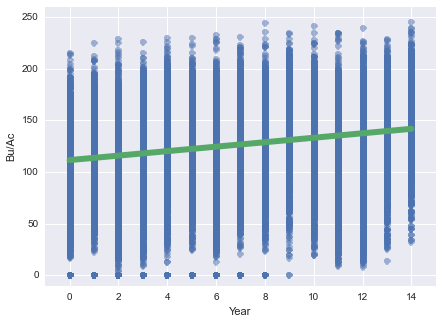

In [7]:
# Plot Bu/Ac vs. Year in Nebraska
xx = np.linspace(0, 14)
plt.figure(figsize=(7, 5))
plt.plot(df.year, df.Value, 'o', alpha=.5)
plt.plot(xx, b0 + b1*xx, lw=6)
plt.xlabel("Year")
plt.ylabel("Bu/Ac")
plt.xlim([-1, 15])
plt.ylim([-10, 260])
plt.show()

## Weather data

In [8]:
# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/us.txt.gz"
# wget.download(url, out="data/ushcn/ushcn_daily.txt.gz")
# subprocess.call(["unpigz", "data/ushcn/ushcn_daily.txt.gz"])

# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/ushcn-stations.txt"
# wget.download(url, out="data/ushcn/ushcn_stations.txt")

# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/data_format.txt"
# wget.download(url, out="data/ushcn/data_format.txt")

In [9]:
!cat data/ushcn/data_format.txt

USHCN daily data are available as ASCII files. 
The format of each record in an ASCII data file, be it a state-level 
file (e.g., state01_AL.txt) or the file for the entire U.S. (us.txt) 
is as follows. (Each record in a file contains one month of daily data.)

Variable 	  	Columns 	  	Type
COOP ID 	  	1-6 	  	Character
YEAR	 	  	7-10 	  	Integer
MONTH 		  	11-12 	  	Integer
ELEMENT 	  	13-16 	  	Character
VALUE1 		  	17-21 	  	Integer
MFLAG1 		  	22 	  	Character
QFLAG1 		  	23 	  	Character
SFLAG1 		  	24 	  	Character
VALUE2 		  	25-29 	  	Integer
MFLAG2 		  	30 	  	Character
QFLAG2 		  	31 	  	Character
SFLAG2 		  	32 	  	Character
. 	  	. 	  	.
. 	  	. 	  	.
. 	  	. 	  	.
. 	  	. 	  	.
VALUE31 	  	257-261 	Integer
MFLAG31 	  	262 	  	Character
QFLAG31 	  	263 	  	Character
SFLAG31 	  	264 	  	Character

These variables have the following definitions:

COOP ID 	is the U.S. Cooperative Observer Network station identification
		code. Note that the first two digits in the Coop Id corr

In [10]:
def fetch_ushcn_values(line):
    n = len(line.strip())
    for i, start_i in enumerate(xrange(16, n-7, 8)):
        end_i = start_i + 5
        yield dt.timedelta(i), int(line[start_i:end_i].strip())
        
def leapyear(date):
    return date.month == 2 and date.day == 29

In [41]:
# Construct PRCP matrix 
# 
# Each row hold the precipitation for 365
# days for a station-year pair
# February 29 is skipped

stations = []
weather_rows = {}
i = 0
for line in open("data/ushcn/ushcn_stations.txt"):
    year_dict = {}
    for year in xrange(2000, 2015):
        year_dict[year] = i
        i += 1
    station_id, lat, lon, elev, state = line.split()[:5]
    stations.append({
        "station": station_id,
        "latitude": float(lat),
        "longitude": float(lon),
        "elevation": float(elev),
        "state_abbreviation": state
    })
    weather_rows[line.split()[0]] = year_dict

stations = pd.DataFrame(stations)

prcp = np.zeros((i, 365))

for line in open("data/ushcn/ushcn_daily.txt"):
    coop_id = line[:6]
    element = line[12:16]
    year = int(line[6:10])
    month = int(line[10:12])
    
    month_begin = dt.datetime(year, month, 1)
    year_begin = dt.datetime(year, 1, 1)
    
    if element == 'PRCP' and 2000 <= year <= 2014:
        for td, val in fetch_ushcn_values(line):
            d = month_begin + td
            if not leapyear(d):
                i = weather_rows[coop_id][year]
                j = (d - year_begin).days
                if year % 4 == 0 and d > dt.datetime(year, 2, 29):
                    j -= 1
                prcp[i, j] = val

In [59]:
stations.head()

,elevation,latitude,longitude,state_abbreviation,station
0,25.9,31.0581,-87.0547,AL,011084
1,7.0,30.5467,-87.8808,AL,012813
2,38.1,32.8347,-88.1342,AL,013160
3,67.1,32.7017,-87.5808,AL,013511
4,132.0,31.8700,-86.2542,AL,013816


## States

In [ ]:
# url = "http://www2.census.gov/geo/docs/reference/state.txt"
# wget.download(url, out="data/states/states.txt")

In [67]:
states = pd.read_csv("data/states/states.txt", delimiter="|")
state_abbreviations = dict(zip(states.STATE_NAME.map(lambda x: x.lower()), states.STUSAB))

## Counties

In [12]:
# url = "https://geonet.esri.com/servlet/JiveServlet/download/183957-26877/UScounties.zip"
# ^^ this doesn't work. Currently downloading by hand and unzipping in data/counties

In [13]:
shp = shapefile.Reader("data/counties/UScounties/UScounties")

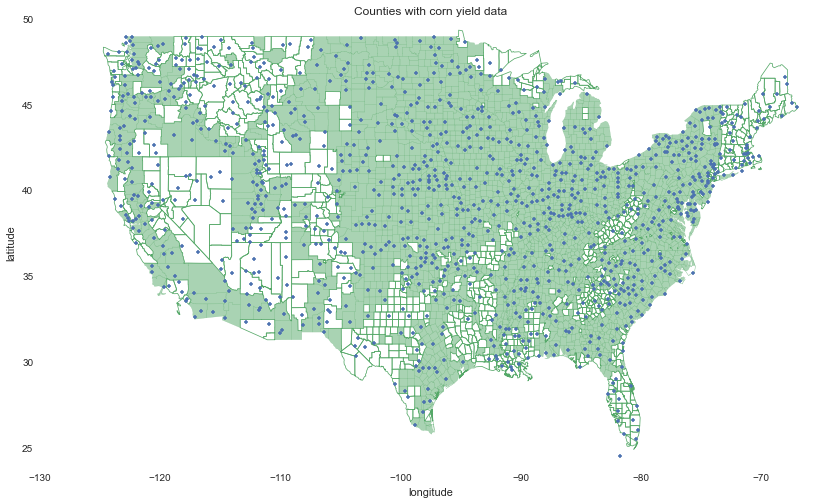

In [132]:
plt.figure(figsize=(14, 8))

fips_set = set(df.fips.values)
county_centroids = []

for record, shape in zip(shp.iterRecords(), shp.shapes()):
    county, state, state_fips, county_fips, fips = record

    if state.lower() not in ["alaska", "hawaii"]:
        X = np.array(shape.points)
        # Plot centroid
        if fips in fips_set:
            lon, lat = X.mean(axis=0)
            plt.fill(X[:, 0], X[:, 1], color=sns.color_palette()[1], alpha=.5)
            county_centroids.append({
                "fips": fips,
                "centroid_x": lon,
                "centroid_y": lat,
                "state_abbrev": state_abbreviations[state.lower()]
            })
        else:
            plt.plot(X[:,0], X[:,1], c=sns.color_palette()[1], lw=.75)
                                    

for s in stations.to_dict(outtype="records"):
    plt.plot(s["longitude"], s["latitude"], ".", c=sns.color_palette()[0])

plt.xlabel("longitude")
plt.ylabel("latitude")

plt.xlim([-130, -65])
plt.ylim([24, 50])

plt.title("Counties with corn yield data")

plt.show()

In [95]:
counties = pd.DataFrame(county_centroids)

In [103]:
counties.head()

,centroid_x,centroid_y,fips,poly,state_abbrev
0,-120.097773,48.353949,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",WA
1,-111.885697,48.483606,30101,POLYGON ((-111.4223100737647 48.21776252169813...,MT
2,-104.653810,48.647436,30091,POLYGON ((-104.0521114628981 48.39101937024861...,MT
3,-103.235361,48.767919,38023,POLYGON ((-102.8850177922477 48.63678161862762...,ND
4,-102.465516,48.732808,38013,"POLYGON ((-102.234169091541 48.54927749886978,...",ND


In [112]:
new_stations = []

for s in stations.to_dict(outtype="records"):
    location_point = Point(s["longitude"], s["latitude"])
    for county in counties[counties.state_abbrev == s["state_abbreviation"]].to_dict(outtype="records"):
        if county["poly"].contains(location_point):
            s["county_fips"] = county["fips"]
            new_stations.append(s)
            break
        else:
            pass

In [87]:
counties.head()

,centroid_x,centroid_y,fips,state_abbrev
0,-120.097773,48.353949,53047,WA
1,-111.885697,48.483606,30101,MT
2,-104.653810,48.647436,30091,MT
3,-103.235361,48.767919,38023,ND
4,-102.465516,48.732808,38013,ND


In [76]:
df = pd.merge(df, , on="fips")

In [78]:
df[["Value", "centroid_x", "centroid_y", "year", "state_abbrev"]].head()

,Value,centroid_x,centroid_y,year,state_abbrev
0,191.5,-87.658325,34.74116,14,AL
1,182.2,-87.658325,34.74116,13,AL
2,102.4,-87.658325,34.74116,12,AL
3,131.3,-87.658325,34.74116,11,AL
4,144.7,-87.658325,34.74116,10,AL
